In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
import xgboost as xgb
from xgboost import XGBClassifier
import seaborn as sns

In [2]:
df_churn = pd.read_csv('./df_churn.csv')
df_churn.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,Active,EstimatedSalary,Exited,Complain,SatScore,CardType,PointsEarned
0,619,0,1,42,2,0.00,1,1,1,101348.88,1,1,2,3,464
1,608,1,1,41,1,83807.86,1,0,1,112542.58,0,1,3,3,456
2,502,0,1,42,8,159660.80,3,1,0,113931.57,1,1,3,3,377
3,699,0,1,39,1,0.00,2,0,0,93826.63,0,0,5,1,350
4,850,1,1,43,2,125510.82,1,1,1,79084.10,0,0,5,1,425


In [10]:
def get_data(x, y):
    
    #let's normalize the columns, so all values in each column [0, 1]
    max_X = np.nanmax(x, axis=0)  
    min_X = np.nanmin(x, axis=0)
    x = (x-min_X)/(max_X-min_X + 1e-9)
    max_Y = np.nanmax(y, axis=0)
    min_Y = np.nanmin(y, axis=0)
    y = (y-min_Y)/(max_Y-min_Y + 1e-9)
    
    print(x)
    
    #shuffle
    shuffled_indices = np.random.permutation(len(y))
    x = x[shuffled_indices]
    y = y[shuffled_indices]
    
    #split into training & validation
    X_train, X_val, Y_train, Y_val = train_test_split(x, y, test_size=0.2, random_state=42)

    return X_train, X_val, Y_train, Y_val

# 1. Logistic regression
Let's write a function that takes as input X and Y (can be training or validation), the batch size, type of optimizer

In [4]:
def run_logistic_reg(X, Y, bs, opt, plot=True): 
    i = tf.keras.Input(shape=(X.shape[1],)) #based on number of features
    o = tf.keras.layers.Dense(1, activation='sigmoid')(i)  #sigmoid activation for logistic regression. Also single layer
    model = tf.keras.Model(inputs=i, outputs=o)
    
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    
    history = model.fit(X, Y, epochs=20, batch_size=bs, verbose=0) #will be used for plotting
    loss_values = history.history['loss']
    accuracy_values = history.history['accuracy']
    
    loss, accuracy = model.evaluate(X, Y)
    print(f"Final Loss: {loss}, Final Accuracy: {accuracy}")
    
    Y_hat = model.predict(X)
    print("Predictions:", Y_hat)

    if plot:
        fig, ax = plt.subplots()

        ax.plot(loss_values, linewidth=2, alpha=0.6, linestyle='-', color='orchid', label="Loss")
        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss', color='orchid')
        ax.tick_params(axis='y', labelcolor='orchid')

        ax1 = ax.twinx()
        ax1.plot(accuracy_values, linewidth=2, alpha=0.6, linestyle='-', color='darkcyan', label="Accuracy")
        ax1.set_ylabel('Accuracy', color='darkcyan')
        ax1.tick_params(axis='y', labelcolor='darkcyan')
        plt.show()

    return Y_hat, model

[[0.538      0.         1.         ... 0.25       1.         0.39160045]
 [0.516      0.5        1.         ... 0.5        1.         0.38251986]
 [0.304      0.         1.         ... 0.5        1.         0.29284904]
 ...
 [0.718      0.         1.         ... 0.5        0.         0.50510783]
 [0.844      1.         0.         ... 0.25       0.33333333 0.24971623]
 [0.884      0.         1.         ... 0.5        1.         0.89897843]]
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14)]              0         
                                                                 
 dense_1 (Dense)             (None, 1)                 15        
                                                                 
Total params: 15
Trainable params: 15
Non-trainable params: 0
_________________________________________________________________
250/250 [======

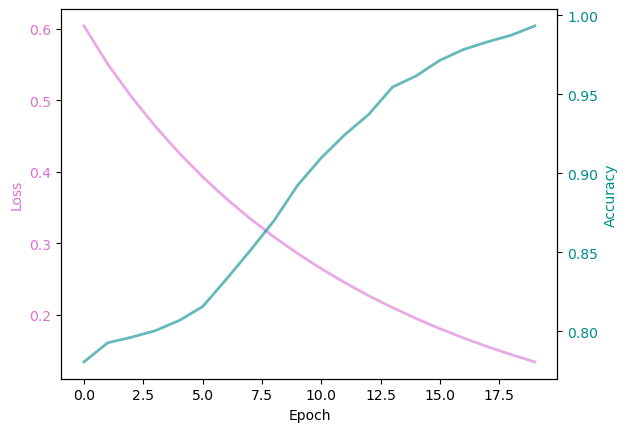

In [11]:
y = df_churn.Exited.to_numpy()
x = df_churn.drop('Exited', axis=1).to_numpy()

X_train, _, Y_train, _ = get_data(x, y)
Y_hat, model = run_logistic_reg(X_train, Y_train, 32, opt='Adam', plot=True)

### this is fantastic! Plot confusion matrix for training data

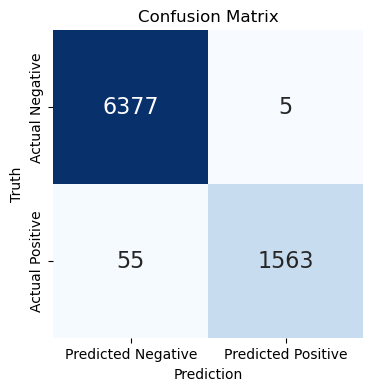

In [12]:
def plot_conf_matrix(Y_data, Y_hat):

    Y_hat = (Y_hat >= 0.5).astype(int).flatten()
    Y_data = np.array([int(round(i)) for i in Y_data]) #astype(int) giving errors :(
    tn, fp, fn, tp = confusion_matrix(Y_data, Y_hat).flatten()

    conf_matrix = np.array([[tn, fp], [fn, tp]])
    
    fig, ax = plt.subplots(figsize=(4, 4))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', \
                xticklabels=['Predicted Negative', 'Predicted Positive'], \
                yticklabels=['Actual Negative', 'Actual Positive'], 
                cbar=False, annot_kws={"size": 16})
    
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Truth')
    ax.set_title('Confusion Matrix')

plot_conf_matrix(Y_train, Y_hat)

### and for validation data

63/63 [==============================] - 0s 1ms/step


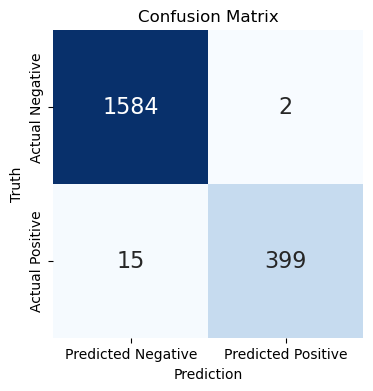

In [13]:
Y_preds_val = model.predict(X_val)
plot_conf_matrix(Y_val, Y_preds_val)

### this is all well and good, but remember that one of our features was too strong of a predictor!! Let's remove it and try logistic regression after that

[[0.538      0.         1.         ... 0.25       1.         0.39160045]
 [0.516      0.5        1.         ... 0.5        1.         0.38251986]
 [0.304      0.         1.         ... 0.5        1.         0.29284904]
 ...
 [0.718      0.         1.         ... 0.5        0.         0.50510783]
 [0.844      1.         0.         ... 0.25       0.33333333 0.24971623]
 [0.884      0.         1.         ... 0.5        1.         0.89897843]]
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 13)]              0         
                                                                 
 dense_3 (Dense)             (None, 1)                 14        
                                                                 
Total params: 14
Trainable params: 14
Non-trainable params: 0
_________________________________________________________________
250/250 [======

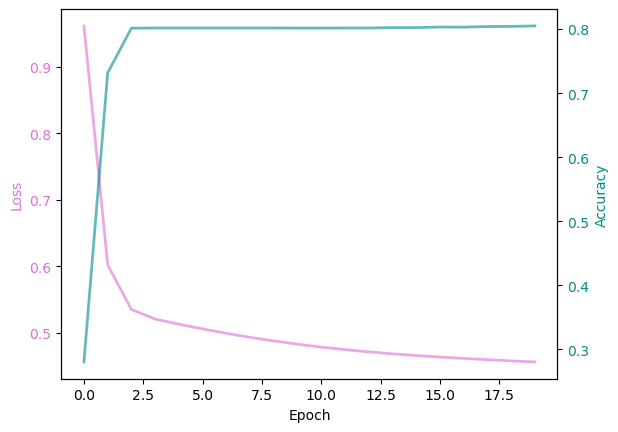

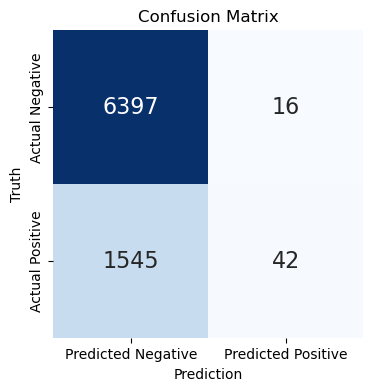

In [15]:
x = df_churn.drop(['Exited', 'Complain'], axis=1).to_numpy() #we will remove complain from the list of predictors because it is such a
    #strong predictor. Comment this out when not in use
y = df_churn.Exited.to_numpy()

X_train, _, Y_train, _ = get_data(x, y)
Y_hat, model = run_logistic_reg(X_train, Y_train, 32, opt='Adam', plot=True)

plot_conf_matrix(Y_train, Y_hat)

### Since complaint was a bit of a ``cheating predictor", it feels much nicer to make predictions without it. Now, the accuracy drops down to 80%, which is not quite so bad

# 2. Time to try using XG Boost for classification
### while exploring the learning rate hyperparameter

In [60]:
y = df_churn.Exited.to_numpy()
#x = df_churn.drop('Exited', axis=1).to_numpy()
x = df_churn.drop(['Exited', 'Complain'], axis=1).to_numpy() #we will remove complain from the list of predictors because it is such a

X_train, X_val, Y_train, Y_val = get_data(x, y)
Y_train = np.array([int(round(i)) for i in Y_train]) 
Y_val = np.array([int(round(i)) for i in Y_val]) 

lr_range = np.linspace(.0, 1., 100)
val_XG = [] 
train_XG = []

for lr in lr_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(X_train, Y_train)
    train_XG.append(xgb_classifier.score(X_train, Y_train))
    val_XG.append(xgb_classifier.score(X_val, Y_val))

[[0.538      0.         1.         ... 0.25       1.         0.39160045]
 [0.516      0.5        1.         ... 0.5        1.         0.38251986]
 [0.304      0.         1.         ... 0.5        1.         0.29284904]
 ...
 [0.718      0.         1.         ... 0.5        0.         0.50510783]
 [0.844      1.         0.         ... 0.25       0.33333333 0.24971623]
 [0.884      0.         1.         ... 0.5        1.         0.89897843]]


0.866


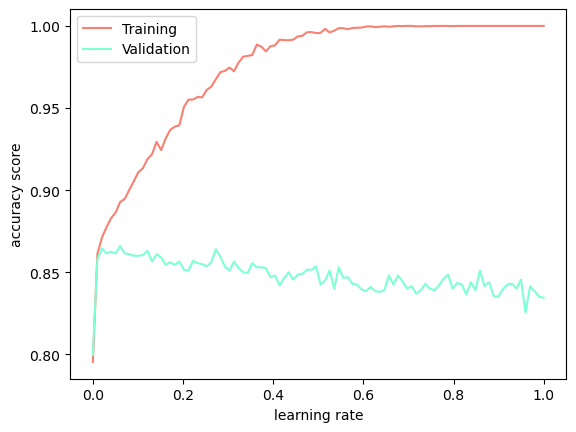

In [61]:
fig, ax = plt.subplots()
ax.plot(lr_range, train_XG, linestyle = '-', color = 'salmon', label='Training')
ax.plot(lr_range, val_XG, linestyle = '-', color = 'aquamarine', label='Validation')
ax.set_xlabel('learning rate')
ax.set_ylabel('accuracy score')
ax.legend()
print(max(val_XG))

### It's doing better than logistic regression, but also doing better on training v. validation, which may hint at overfitting issues. Can we beat validation accuracy of 85%?
### let's choose a small value for lr and explore the max depth hyperparam. Higher max depth values can often lead to overfitting, so maybe smallers values is the way to go

In [70]:
md_range = [2, 3, 4, 5, 6, 7, 10, 40]
val_XG = [] 
train_XG = []

for md in md_range:
    xgb_classifier = xgb.XGBClassifier(eta = .01, max_depth = md)
    xgb_classifier.fit(X_train, Y_train)
    train_XG.append(xgb_classifier.score(X_train, Y_train))
    val_XG.append(xgb_classifier.score(X_val, Y_val))

0.858


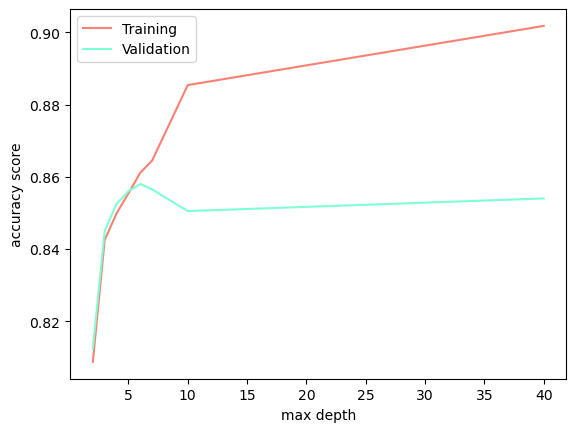

In [71]:
fig, ax = plt.subplots()
ax.plot(md_range, train_XG, linestyle = '-', color = 'salmon', label='Training')
ax.plot(md_range, val_XG, linestyle = '-', color = 'aquamarine', label='Validation')
ax.set_xlabel('max depth')
ax.set_ylabel('accuracy score')
ax.legend()
print(max(val_XG))

### does not appear to change the validation accuracy much. Let's try regularization, which is meant to add a penalty to the weights such that we favor less complex models. $\lambda$ controls L2 regularization, also known as Ridge

In [74]:
lambda_list = np.linspace(0, 5, 25)
val_XG = [] 
train_XG = []

for lambda_ in lambda_list:
    xgb_classifier = xgb.XGBClassifier(eta = .01, max_depth = 6, reg_alpha = lambda_)
    xgb_classifier.fit(X_train, Y_train)
    train_XG.append(xgb_classifier.score(X_train, Y_train))
    val_XG.append(xgb_classifier.score(X_val, Y_val))

0.8585


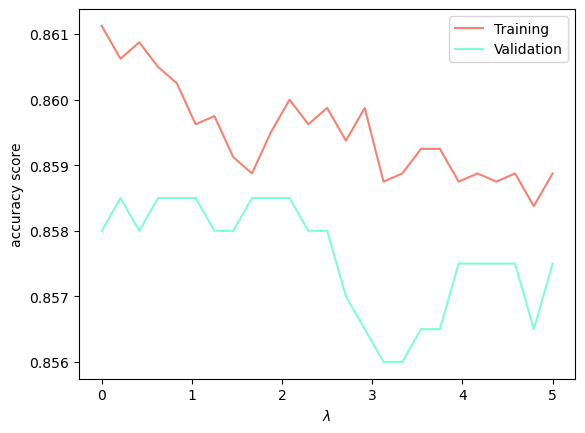

In [75]:
fig, ax = plt.subplots()
ax.plot(lambda_list, train_XG, linestyle = '-', color = 'salmon', label='Training')
ax.plot(lambda_list, val_XG, linestyle = '-', color = 'aquamarine', label='Validation')
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel('accuracy score')
ax.legend()
print(max(val_XG))

### Not changing much. Let's try changing the min. child weight? 
### High MCW makes the algo bit more conservative, preventing leaf formation below a certain threshold set by this hyperparam

In [81]:
mcw_list = np.linspace(0, 10, 11)
val_XG = [] 
train_XG = []

for mcw in mcw_list:
    xgb_classifier = xgb.XGBClassifier(eta = .01, max_depth = 6, reg_alpha = .01, min_child_weight = mcw)
    xgb_classifier.fit(X_train, Y_train)
    train_XG.append(xgb_classifier.score(X_train, Y_train))
    val_XG.append(xgb_classifier.score(X_val, Y_val))

0.8615


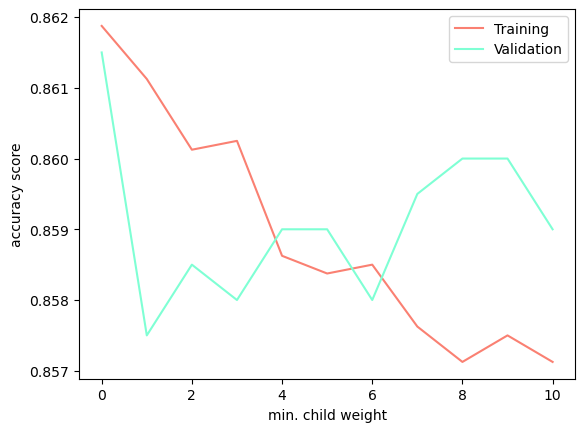

In [83]:
fig, ax = plt.subplots()
ax.plot(mcw_list, train_XG, linestyle = '-', color = 'salmon', label='Training')
ax.plot(mcw_list, val_XG, linestyle = '-', color = 'aquamarine', label='Validation')
ax.set_xlabel('min. child weight')
ax.set_ylabel('accuracy score')
ax.legend()
print(max(val_XG))

### How about early stopping? 

In [96]:
esr_list = np.linspace(0, 20, 21)
val_XG = [] 
train_XG = []

for esr in esr_list:
    
    model = XGBClassifier(n_estimators=1000, eta = .01, early_stopping_rounds=esr, eval_metric='logloss')

    model.fit(X_train, Y_train, eval_set=[(X_val, Y_val)], verbose=False)
        
    train_XG.append(model.score(X_train, Y_train))
    val_XG.append(model.score(X_val, Y_val))

0.864


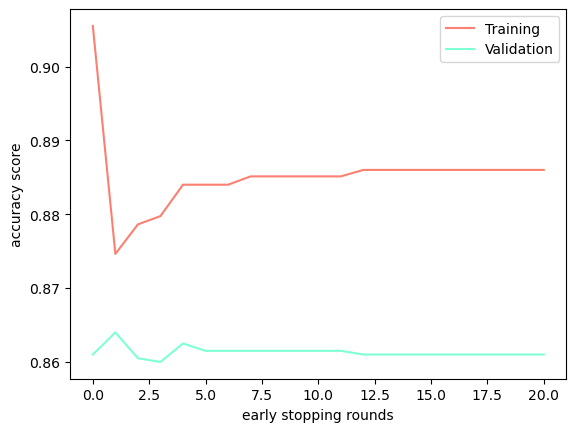

In [97]:
fig, ax = plt.subplots()
ax.plot(esr_list, train_XG, linestyle = '-', color = 'salmon', label='Training')
ax.plot(esr_list, val_XG, linestyle = '-', color = 'aquamarine', label='Validation')
ax.set_xlabel('early stopping rounds')
ax.set_ylabel('accuracy score')
ax.legend()
print(max(val_XG))